In [38]:
import sys, os
sys.path.insert(0, os.path.abspath("utils"))
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

### Get the aligned transcripts (textgrids) of the story
Load up the stimuli. Here, instead of audio waveforms, we are dealing with aligned transcripts. These were generated using the UPenn forced aligner (P2FA), which figures out when each word was spoken given the transcript and the audio. The transcripts are stored in TextGrid format (native to Praat), which can be loaded directly into Python using some code from the natural language toolkit (NLTK).

Load the TextGrids for the stories, as well as 'TRfiles', which specify the time points relative to story onset when the fMRI data was collected (roughly every 2 seconds).

Finally, combine the TextGrids and TRfiles together into a representation I call a DataSequence. 

In [39]:
# load textgrid
from stimulus_utils import load_grids_for_stories
story = ['wheretheressmoke']
grids = load_grids_for_stories(story)

# load TRfiles
from stimulus_utils import load_generic_trfiles
trfiles = load_generic_trfiles(story)

# Make word and phoneme datasequences
from dsutils import make_word_ds, make_phoneme_ds
wordseqs = make_word_ds(grids, trfiles) # dictionary of {storyname : word DataSequence}
phonseqs = make_phoneme_ds(grids, trfiles) # dictionary of {storyname : phoneme DataSequence}

In [40]:
smoke = wordseqs['wheretheressmoke']
print ("There are %d words in the story called 'smoke'" % len(list(smoke.data)))
print (list(smoke.data)[:10])
# data_times stores when exactly each word was spoken (this time corresponds to the middle of each word)
print (smoke.data_times[:10]) 
# tr_times stores the time of the middle of each fMRI acquisition (each acqusition takes 2.0045 seconds)
# these times are relative to story start, so the fMRI scan started 10 seconds before the story
print (smoke.tr_times[:10])
# and it also makes it easy to, for example, find the words that were spoken during each fMRI acquisition
# (the first few are empty because they came before the story started)
print (smoke.chunks()[:10])

There are 1839 words in the story called 'smoke'
['i', 'reached', 'over', 'and', 'secretly', 'undid', 'my', 'seatbelt', 'and', 'when']
[0.07732426 0.32176871 0.730839   1.6138322  2.05283447 2.68639456
 3.02562358 3.4047619  4.59965653 4.75170068]
[-9.02120481 -7.03103081 -5.02295181 -3.02288181 -1.01475881  0.98530419
  2.99351619  4.99353919  7.00168919  9.00984419]
[array([], dtype='<U13'), array([], dtype='<U13'), array([], dtype='<U13'), array([], dtype='<U13'), array([], dtype='<U13'), array(['i', 'reached', 'over', 'and', 'secretly'], dtype='<U13'), array(['undid', 'my', 'seatbelt'], dtype='<U13'), array(['and', 'when', 'his', 'foot', 'hit', 'the'], dtype='<U13'), array(['brake', 'at', 'the', 'red', 'light', 'i', 'flung', 'open'],
      dtype='<U13'), array(['the', 'door', 'and', 'i', 'ran'], dtype='<U13')]


The transcript of the entire story:

In [52]:
print(len(smoke.chunks()))

306


In [41]:
print (" ".join(list(smoke.data)))

i reached over and secretly undid my seatbelt and when his foot hit the brake at the red light i flung open the door and i ran i had no shoes on i was crying i had no wallet but i was ok because i had my cigarettes and i didn't want any part of freedom if i didn't have my cigarettes when you live with someone who has a temper a very bad temper a very very bad temper you learn to play around that you learn this time i'll play possum and next time i'll just be real nice or i'll say yes to everything or you make yourself scarce or you run and this was one of the times when you just run and as i was running i thought this was a great place to jump out because there were big lawns and there were cul de sacs and sometimes he would come after me and drive and yell stuff at me to get back in get back in and i was like no i'm out of here this is great and i went and hid behind a cabana and he left and i had my cigarettes and uh i started to walk in this beautiful neighborhood it was ten thirty 

### Get stimulus properties (surprisal, word rate, word coverage)
Import the timestamps of the randomly sampled 10s clips 

In [42]:
import json
clip_len = 10
with open("data/audios/10s_clips/wheretheressmoke_timestamps.json") as f:
    timestamps = json.load(f)
print(timestamps)
start_times = np.array(list(timestamps.values()))

{'wheretheressmoke_000.wav': 54.9071875, 'wheretheressmoke_001.wav': 280.6798125, 'wheretheressmoke_002.wav': 91.4218125, 'wheretheressmoke_003.wav': 427.0239375, 'wheretheressmoke_004.wav': 279.501875, 'wheretheressmoke_005.wav': 112.931875, 'wheretheressmoke_006.wav': 40.007, 'wheretheressmoke_007.wav': 397.540625, 'wheretheressmoke_008.wav': 562.2485625, 'wheretheressmoke_009.wav': 589.633875, 'wheretheressmoke_010.wav': 348.3345, 'wheretheressmoke_011.wav': 357.3528125, 'wheretheressmoke_012.wav': 54.4228125, 'wheretheressmoke_013.wav': 167.418125, 'wheretheressmoke_014.wav': 141.618, 'wheretheressmoke_015.wav': 353.59725, 'wheretheressmoke_016.wav': 588.21125, 'wheretheressmoke_017.wav': 350.010875, 'wheretheressmoke_018.wav': 257.072375, 'wheretheressmoke_019.wav': 171.7324375, 'wheretheressmoke_020.wav': 1.7516875, 'wheretheressmoke_021.wav': 457.4683125, 'wheretheressmoke_022.wav': 91.869375, 'wheretheressmoke_023.wav': 395.9368125, 'wheretheressmoke_024.wav': 73.27125, 'wheret

In [43]:
end_times = start_times + clip_len 
word_times = np.asarray(smoke.data_times) 
words = np.asarray(smoke.data)
clip_words = []
clip_times = []
for i in range(len(start_times)):
    start_time = float(start_times[i])
    end_time = float(end_times[i])
    mask = (word_times >= start_time) & (word_times <= end_time)
    words_in_window = words[mask].tolist()
    clip_words.append(words_in_window)
    data_times_in_window = word_times[mask].tolist()
    clip_times.append(data_times_in_window)

for i, wlist in enumerate(clip_words):
    print(f"Clip {i:03d}: {wlist}")

Clip 000: ['sacs', 'and', 'sometimes', 'he', 'would', 'come', 'after', 'me', 'and', 'drive', 'and', 'yell', 'stuff', 'at', 'me', 'to', 'get', 'back', 'in', 'get', 'back', 'in', 'and', 'i', 'was', 'like', 'no', "i'm", 'out', 'of', 'here', 'this', 'is', 'great', 'and', 'i', 'went', 'and', 'hid', 'behind', 'a', 'cabana', 'and', 'he', 'left']
Clip 001: ['how', 'it', 'can', 'still', 'be', 'pretty', 'she', 'understands', 'like', 'how', 'nice', "he's", 'gonna', 'be', 'when', 'i', 'get', 'home', 'and', 'how', 'sweet', "that'll", 'be', 'we']
Clip 002: ['and', 'enjoying', 'these', 'few', 'hours', 'i', 'knew', "i'd", 'have', 'of', 'freedom', 'and', 'just', 'to', 'perfect', 'it', 'i', 'thought', "i'll", 'have', 'a', 'smoke', 'and', 'then', 'it', 'occurred', 'to', 'me']
Clip 003: ['and', 'she', 'taps', 'out', 'the', 'last', 's', 'pack', 'of', 'cigarettes', 'in', 'there', 'and', 'on', 'the', 'way', 'up', 'she', 'kisses', 'the', 'little', 'boy', 'and', 'then', 'she', 'kisses', 'the', 'man', 'and', 't

#### Get word rate and word coverage for each sentence

In [44]:
# word rate = words / second
word_rate_per_sentence = [len(clip_words[i])/clip_len for i in range(len(clip_words))] 
out_dir = "./data/audios/10s_clips"
save_path = os.path.join(out_dir, "word_rate_per_sentence.npy")
np.save(save_path, np.array(word_rate_per_sentence))

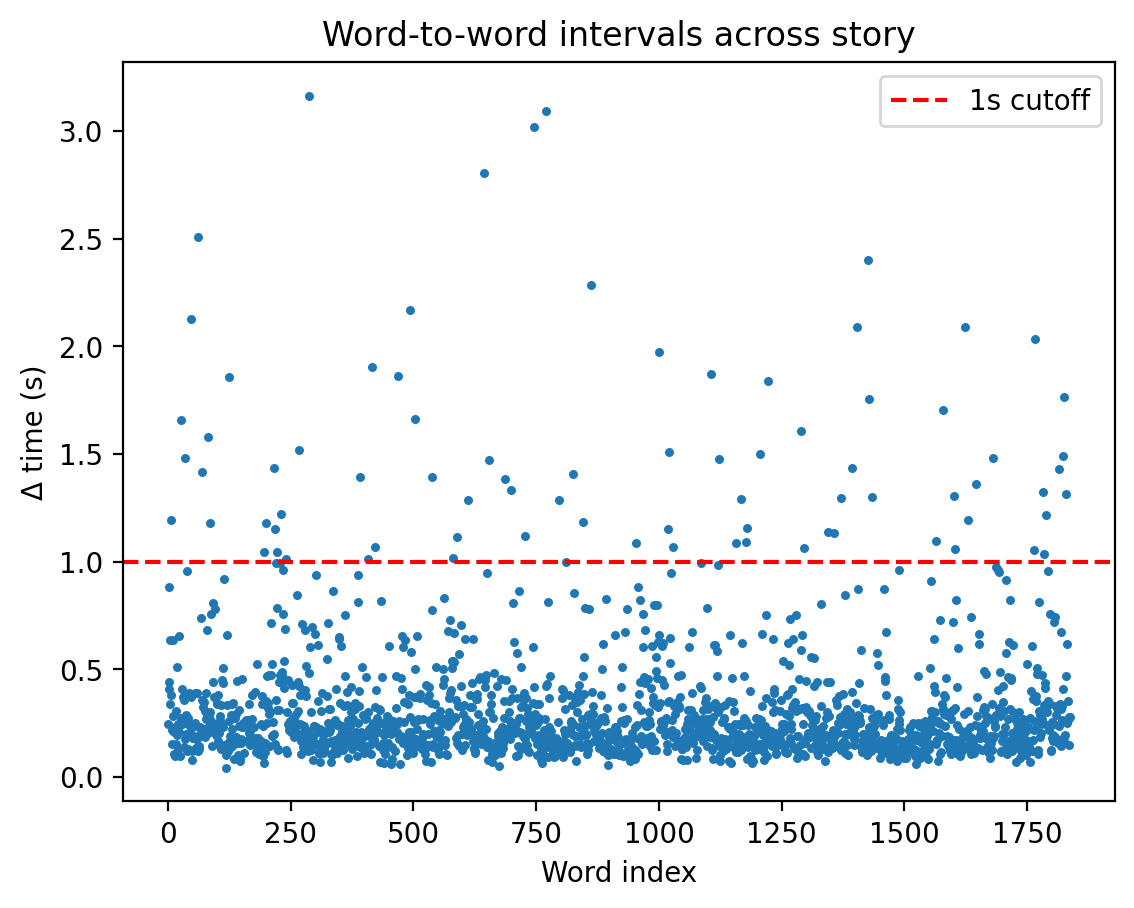

[np.float64(0.9717913832199997), np.float64(0.619092970500003), np.float64(0.7832199546499993), np.float64(0.8610430838999946), np.float64(0.7358276643500006), np.float64(0.9488435374499999), np.float64(0.8036734693850001), np.float64(0.7986848073000032), np.float64(0.5851932156054772), np.float64(0.13269841275000543), np.float64(0.9548299320000012), np.float64(0.7343310656999904), np.float64(0.9792743764150004), np.float64(0.6522921252598962), np.float64(0.6355555556000041), np.float64(0.9678004535499951), np.float64(0.21950113384999667), np.float64(0.95632653065), np.float64(0.6789569161000031), np.float64(0.7712471655000002), np.float64(0.6703220618276469), np.float64(0.4444897959499997), np.float64(0.7742403628099993), np.float64(0.7463038548500094), np.float64(0.5507482993199971), np.float64(0.6476346538755552), np.float64(0.6790134402327908), np.float64(0.9034467120500039), np.float64(0.9538321995500013), np.float64(0.8016780045349996), np.float64(0.5856689342649986), np.float64(

In [45]:
# word coverage = the fraction of the time taken up by words
word_durations = np.diff(smoke.data_times)
plt.scatter(range(len(word_durations)), word_durations, s=5)
plt.axhline(1.0, color='r', linestyle='--', label='1s cutoff')
plt.xlabel("Word index")
plt.ylabel("Δ time (s)")
plt.legend()
plt.title("Word-to-word intervals across story")
plt.show()

# filter out long durations as those are probably pauses (one word should take no more than 1s)
word_coverage_per_sent = []
for sentence_i in range(len(clip_words)):
    word_duration = np.diff(np.array(clip_times[sentence_i]))
    word_duration_filtered = word_duration[word_duration < 1.0]
    word_duration_sum = np.sum(word_duration_filtered)
    word_coverage = word_duration_sum / clip_len
    word_coverage_per_sent.append(word_coverage)

print(word_coverage_per_sent)
out_dir = "./data/audios/10s_clips"
save_path = os.path.join(out_dir, "word_coverage_per_sentence.npy")
np.save(save_path, np.array(word_coverage_per_sent))


#### Get average sentence surprisal 

In [46]:
import math
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# 1) Load GPT-2 + fast tokenizer
device = torch.device("cpu")
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2", add_prefix_space=True)
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device).eval()

def sentence_word_surprisal_gpt2(words, add_special_tokens=False):
    """
    words: list[str] for one sentence.
    returns: 
        word_surprisal: surprisal for each word (summed over tokens), in bits
        mean_sentence_surprisal: sum surprisal for each sentence, then divide by number of words, in bits
    """
    # 2) tokenize as pre-slit words so we can map tokens to word idx
    enc = tokenizer(
        words,
        is_split_into_words=True,
        return_tensors='pt',
        add_special_tokens=add_special_tokens,
        return_attention_mask=True
    )
    input_ids = enc["input_ids"]
    model_inputs = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        out = model(**model_inputs) # logits over next-token distribution, shape [batch_size, sequence_len, vocab_size of GPT]

    # 3) next-token log-prob for the actually observed sequence
    logits = out.logits[:, :-1, :] # for each token, this gives a vector, of length (vocab_size), a distribution of how probable each word is as the next word (this is the model's prediction of next word)
    labels = input_ids[:, 1:] # actual words
    log_probs = torch.log_softmax(logits, dim=-1) # turning logits into log probabilities (same shape as logits)
    token_logp = log_probs.gather(dim=-1, index=labels.unsqueeze(-1)).squeeze(-1) # get the log_prob where the last dimension (vocab) matches the label
    token_bits = (-token_logp / math.log(2)).squeeze(0)

    # 4) map tokens back to words
    word_ids = enc.word_ids() # length = Ttok
    word_ids_for_targets = word_ids[1:] 
    word_surprisal = []
    current = None
    acc = 0 # accumulate token surprisals
    have_tokens = False

    def flush():
        nonlocal acc, have_tokens # nonlocal lets the function modify things defined outside of it
        if have_tokens:
            word_surprisal.append(float(acc))
            acc = 0
            have_tokens = False

    for word_id, bit in zip(word_ids_for_targets, token_bits.tolist()):
        if word_id is None: # token not associated with a word
            continue
        if (current is None) or (word_id == current):
            acc += bit
            have_tokens = True
            current = word_id
        else:
            # move to next word
            flush()
            current = word_id
            acc = bit
            have_tokens = True
    flush()

    # 5) sentence-level aggregation
    mean_sentence_surprisal = float(sum(word_surprisal) / len(word_surprisal))

    return word_surprisal, mean_sentence_surprisal 


In [47]:
# suppose `clip_words` is a list of sentences, each sentence is list[str] as in your screenshot
# e.g., sentences = clip_words  # or whatever variable holds your per-sentence word-lists
def compute_surprisal_for_many(sentences):
    per_sentence_surprisal = []
    for s_idx, words in enumerate(sentences):
        w_bits, sent_mean = sentence_word_surprisal_gpt2(words)
        per_sentence_surprisal.append({
            "index": s_idx,
            "words": words,
            "word_surprisal_bits": w_bits,
            "sentence_surprisal_mean_bits": sent_mean,
        })
    return per_sentence_surprisal 


mean_sentence_surprisal = compute_surprisal_for_many(clip_words)
# Export to JSON
save_path = os.path.join(out_dir, "gpt2_sentence_surprisal.json")
with open(save_path, "w", encoding="utf-8") as f:
    json.dump(mean_sentence_surprisal, f, indent=2, ensure_ascii=False)


In [48]:
print(mean_sentence_surprisal[0]["sentence_surprisal_mean_bits"])
print(mean_sentence_surprisal[9]["sentence_surprisal_mean_bits"])

5.707668595512708
9.052287149429322
